#### Importing libraries

In [19]:
import pandas as pd
import matplotlib as plt
import numpy as np
from fuzzywuzzy import process
import scipy.io
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import seaborn as sns
from weighted_correlation import weighted_correlation
from weighted_spearman import weighted_spearman

#### Reading and cleaning the datasets

##### Base dataset
Air pollution data

In [20]:
airdf = pd.read_excel("who_ambient_air_quality_database_version_2024_(v6.1).xlsx", sheet_name="Update 2024 (V6.1)")


# Filter by US
airdf = airdf[airdf["country_name"] == "United States of America"]

# Drop unnnecessary columns
airdf = airdf.drop(['country_name', 'version','reference','web_link', 'population_source','who_ms', 'type_of_stations', 'population', 'latitude', 'longitude', 'iso3', 'who_region', 'pm25_tempcov', 'pm10_tempcov','no2_tempcov'], axis=1)

# Remove state from city names
airdf['city'] = airdf['city'].str.split(' ').str[0]
airdf['city'] = airdf['city'].str.split('-').str[0]
# Leave only year 2020
airdf = airdf[airdf['year'] == 2020.0]


##### Additional dataset
Healt measure data


In [21]:
df = pd.read_csv("PLACES_Local_Data_for_Better_Health_County_Data_2022_release_20250320.csv")

df = df[df["Data_Value_Type"].str.contains("Age", na=False)]
df = df[df['TotalPopulation'] > 100000]

# Rename the city column
df = df.rename(columns={"LocationName": "city"})


# Drop unnecessary columns
df = df.drop(['StateAbbr', 'StateDesc', 'DataSource', 'Category', 'LocationID', 'CategoryID', 'DataValueTypeID', 'Geolocation', 'Low_Confidence_Limit', 'High_Confidence_Limit', 'Data_Value_Footnote_Symbol', 'MeasureId', 'Data_Value_Footnote' ], axis=1)
# First, let's identify the unique cities and measures
unique_cities = df['city'].unique()
unique_measures = df['Short_Question_Text'].unique()

# print(f"Number of unique cities: {len(unique_cities)}")
# print(f"Number of unique measures: {len(unique_measures)}")



# Create a pivot table with cities as index and measures as columns
new_df = df.pivot_table(
    index='city',
    columns='Measure',
    values='Data_Value',
    aggfunc='mean'  # Use mean if there are duplicate entries
)

population_df = df.groupby('city')['TotalPopulation'].first().reset_index()

# Reset the index to make 'city' a column again
new_df = new_df.reset_index()

# Drop columns that are not needed for the analysis
new_df = new_df.drop([
'Current lack of health insurance among adults aged 18-64 years',
'Cervical cancer screening among adult women aged 21-65 years',
'Visits to dentist or dental clinic among adults aged >=18 years',
'Visits to doctor for routine checkup within the past year among adults aged >=18 years',
'Mammography use among women aged 50-74 years',
'Cholesterol screening among adults aged >=18 years',
'Older adult men aged >=65 years who are up to date on a core set of clinical preventive services: Flu shot past year, PPV shot ever, Colorectal cancer screening',
'Fecal occult blood test, sigmoidoscopy, or colonoscopy among adults aged 50-75 years',
'Older adult women aged >=65 years who are up to date on a core set of clinical preventive services: Flu shot past year, PPV shot ever, Colorectal cancer screening, and Mammogram past 2 years',
'All teeth lost among adults aged >=65 years',
'Arthritis among adults aged >=18 years',
'Binge drinking among adults aged >=18 years',
# 'Current smoking among adults aged >=18 years',
'Diagnosed diabetes among adults aged >=18 years',
'High cholesterol among adults aged >=18 years who have been screened in the past 5 years',
'No leisure-time physical activity among adults aged >=18 years',
'No leisure-time physical activity among adults aged >=18 years',
'Sleeping less than 7 hours among adults aged >=18 years',
'Stroke among adults aged >=18 years',
'Taking medicine for high blood pressure control among adults aged >=18 years with high blood pressure'
], axis=1)

# All diseases
numberOfDiseases = len(list(df['Measure'].unique()))


df.head()
# print(new_df.columns)



,Year,city,Measure,Data_Value_Unit,Data_Value_Type,Data_Value,TotalPopulation,Short_Question_Text
16,2020,Maricopa,Visits to dentist or dental clinic among adult...,%,Age-adjusted prevalence,61.7,4579081,Dental Visit
19,2020,Yavapai,Current asthma among adults aged >=18 years,%,Age-adjusted prevalence,11.1,240226,Current Asthma
29,2020,Kern,Chronic obstructive pulmonary disease among ad...,%,Age-adjusted prevalence,7.3,901362,COPD
32,2020,Monterey,"Fecal occult blood test, sigmoidoscopy, or col...",%,Age-adjusted prevalence,57.7,430906,Colorectal Cancer Screening
38,2020,Sonoma,Diagnosed diabetes among adults aged >=18 years,%,Age-adjusted prevalence,8.2,489819,Diabetes


##### Matching cities using fuzzywuzzy

In [22]:
def find_best_match_city(city, citylist, threshold=95):
    best_match, score = process.extractOne(city, citylist)
    if score >= threshold:
        return best_match
    else: city

airdf['city'] = airdf['city'].apply(lambda x: find_best_match_city(x, unique_cities))

##### Merging the two datasets based on the matched cities

In [23]:
merged_df = pd.merge(new_df, airdf, on='city', how='inner')
merged_df = pd.merge(merged_df, population_df, on='city', how='left')
merged_df = merged_df.drop_duplicates(subset='city', keep='first')

# Optional: print some information about the merged DataFrame
# print(f"Shape of dataframe: {merged_df.shape}")
print("Columns with non-null values for:")
print(f"PM10 concentrations  - {merged_df['pm10_concentration'].notna().sum()}")
print(f"PM2.5 concentrations - {merged_df['pm25_concentration'].notna().sum()}")
print(f"NO2 concentrations   - {merged_df['no2_concentration'].notna().sum()}")

Columns with non-null values for:
PM10 concentrations  - 37
PM2.5 concentrations - 61
NO2 concentrations   - 30


#### Testing the normality of the data

In [ ]:
#This puts merged df into an array to use Scipy

array = merged_df.to_numpy()

# print(array.shape)

# array[:,6]


(63, 18)


array([14.5, 10.9, 15.6, 16.7, 13.8, 21.450000000000003, 18.9, 11.3, 17.6,
       12.8, 15.3, 14.7, 19.7, 17.7, 14.1, 16.4, 13.6, 14.5, 21.0, 17.55,
       20.2, 14.2, 16.5, 15.0, 18.7, 18.375, 22.4, 18.8, 18.0, 17.95,
       16.933333333333334, 18.2, 19.1, 18.1, 20.0, 15.4, 17.675, 15.0,
       22.5, 18.2, 14.2, 20.4, 17.924999999999997, 16.05, 18.1, 19.6,
       15.7, 17.6, 18.25, 13.0, 18.4, 12.6, 9.5, 18.6, 14.9, 18.5, 18.2,
       15.811111111111112, 19.8, 14.9, 17.5, 17.533333333333335, 16.4],
      dtype=object)

In [30]:

column_data = np.array(array[:,6], dtype=float)  # Convert to float

# Perform KS test against normal distribution
ks_statistic, p_value = stats.kstest(column_data, 'norm')
# Normalise for the KS test
column_data = (column_data - np.mean(column_data)) / np.std(column_data)

print(f"KS Statistic: {ks_statistic}")
print(f"P-value: {p_value}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: Data is NOT normally distributed.")
else:
    print("Fail to reject the null hypothesis: Data is likely normally distributed.")


#Here we note that the result is extremely suspicious, therfore we perform different tests(probably more suited for large datasets and normality testing)

KS Statistic: 1.0
P-value: 0.0
Reject the null hypothesis: Data is NOT normally distributed.


In [31]:
#Shapiro-Wilk normality test
stat, p_value = shapiro(column_data)
print(f"Shapiro-Wilk p-value: {p_value}")

# D'Agostino and Pearson's test
from scipy.stats import normaltest
stat, p_value = normaltest(column_data)
print(f"D'Agostino-Pearson p-value: {p_value}")

Shapiro-Wilk p-value: 0.45803582668304443
D'Agostino-Pearson p-value: 0.44236580025354644


#### Weighted spearman's correlation matrix

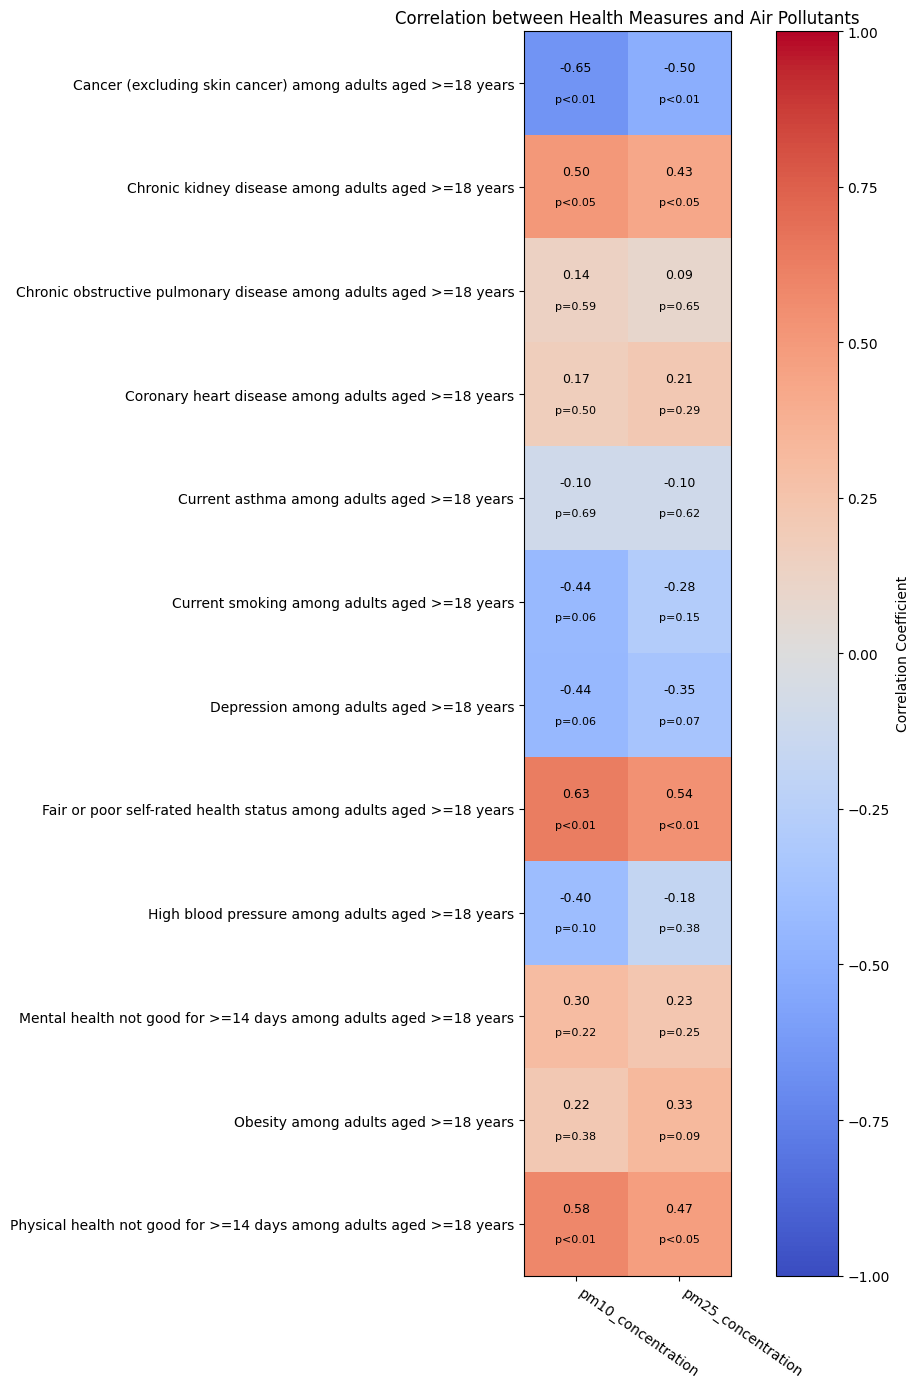

In [40]:
# Print all column names to identify the correct ones
# print("Merged dataframe columns:", merged_df.columns.tolist())

# Update these with the ACTUAL column names from your print output
pollutants = ['pm10_concentration', 'pm25_concentration']  # Use the correct names

# Get disease columns
disease_columns = [col for col in new_df.columns if col != 'city']

# Create a correlation matrix between pollutants and diseases
# correlation_matrix = merged_df[pollutants + disease_columns].corr()
# Create a weighted correlation matrix between pollutants and diseases
correlation_matrix = pd.DataFrame(index=disease_columns, columns=pollutants)
p_value_matrix = pd.DataFrame(index=disease_columns, columns=pollutants)

# Extract weights (population values)
weights = merged_df['TotalPopulation']

# Calculate weighted correlation for each pollutant-disease pair
for disease in disease_columns:
    for pollutant in pollutants:
        # Extract the data
        data_i = merged_df[disease]
        data_j = merged_df[pollutant]
        
        # Create mask for non-NaN values in both columns
        mask = ~data_i.isna() & ~data_j.isna()
        
        # Skip if insufficient data
        if mask.sum() < 3:
            correlation_matrix.loc[disease, pollutant] = np.nan
            p_value_matrix.loc[disease, pollutant] = np.nan
            continue
        
        # Calculate weighted correlation using the function
        try:
            corr_value, p_value = weighted_spearman(
                data_i[mask].values, 
                data_j[mask].values, 
                weights[mask].values
            )
            correlation_matrix.loc[disease, pollutant] = corr_value
            p_value_matrix.loc[disease, pollutant] = p_value
            # print(f"{disease} and {pollutant}: {corr_value}, p={p_value}")
        except Exception as e:
            # print(f"Error calculating correlation for {disease} and {pollutant}: {e}")
            correlation_matrix.loc[disease, pollutant] = np.nan
            p_value_matrix.loc[disease, pollutant] = np.nan
            

# Extract and transpose the correlation matrix - diseases as rows and pollutants as columns
disease_pollutant_corr = correlation_matrix.loc[disease_columns, pollutants]
# print(disease_pollutant_corr)


# Display the correlation matrix
# print("Correlation between health measures and air pollutants:")
# print(disease_pollutant_corr)

# # Visualize the correlation matrix as a heatmap using matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 14))  # Adjusted for more rows than columns
# Convert correlation values to float
disease_pollutant_corr = disease_pollutant_corr.astype(float)

# Create the heatmap
im = plt.imshow(disease_pollutant_corr, cmap='coolwarm', vmin=-1, vmax=1)

# Add colorbar
cbar = plt.colorbar(im)
cbar.set_label('Correlation Coefficient')

# Add labels and title
plt.title('Correlation between Health Measures and Air Pollutants')
plt.xticks(np.arange(len(pollutants)), pollutants, rotation=-35, ha='left')
plt.yticks(np.arange(len(disease_columns)), disease_columns, rotation=0)  # Changed rotation to 0

# Add correlation values and p-values as text annotations
for i in range(len(disease_columns)):
    for j in range(len(pollutants)):
        corr_value = disease_pollutant_corr.iloc[i, j]
        p_value = p_value_matrix.iloc[i, j]
        
        # Format the correlation value
        corr_text = f'{corr_value:.2f}'
        
        # Format the p-value with scientific notation for small values
        if pd.notna(p_value):
            if p_value < 0.001:
                p_text = 'p<0.001'
            elif p_value < 0.01:
                p_text = 'p<0.01'
            elif p_value < 0.05:
                p_text = 'p<0.05'
            else:
                p_text = f'p={p_value:.2f}'
        else:
            p_text = 'p=NA'
        
        # Add correlation value at the top of the cell
        plt.text(j, i-0.15, corr_text, ha="center", va="center", color="black", fontsize=9)
        
        # Add p-value at the bottom of the cell
        plt.text(j, i+0.15, p_text, ha="center", va="center", color="black", fontsize=8)

plt.tight_layout()
plt.savefig('corr_weighted_spearman.png')
plt.show()

#### Calculating p-values for the correlation coefficients

In [28]:
# whole_population = np.sum(array[:,numberOfDiseases-1])
# print(whole_population)
# wheighting_array = array[:,numberOfDiseases]/whole_population
# wheighting_array


In [29]:
# #This is a test correlation for one disease 

# X1=array[:,14]*wheighting_array
# Y=array[:,23]
# print(array[:,14])
# print(X1)

# x = X1.astype(float)
# y = Y.astype(float)

# mask = ~np.isnan(y)& ~np.isnan(x)

# Y_filtered=y[mask]
# X1_filtered=x[mask]

# res = stats.pearsonr(X1_filtered, Y_filtered)

# res

Now we want to find out whether the data is normally distributed so that we know how to compute the correlation

We find this result extremely suspicious hence we use different test satatistics for checking normality

Here we find that the data is indeed normally distributed and as KS test is very prone to overinterpretation of outlying values and not suited for large datasets, we trust Shapiro-Wilk test and decide to go for pearson correlation test without permutation

In [32]:
n = array.shape[1]

air_pollution_parameter = [n-3,n-2,n-1]
disease_range_start = 1
disease_range_end = numberOfDiseases

#permutation_model=stats.PermutationMethod(n_resamples=99999, batch=None, random_state=None, rng=None)

# Ensure Corr array matches the range
Corr_p_values = np.zeros((disease_range_end - disease_range_start + 1,len(air_pollution_parameter)))
Corr_coef = np.zeros((disease_range_end - disease_range_start + 1,len(air_pollution_parameter)))

#This computes p-values of pearson correlation test statistic between diseases and different air pollutants and puts it into a 21x3 array
for j in range(0,len(air_pollution_parameter)):
    y = array[:, air_pollution_parameter[j]]

    for i in range(disease_range_start, disease_range_end + 1):
        try:
            # Extract disease column
            a = array[:, i]#*wheighting_array
            
            # Convert to float as datasets are super messy
            a_float = a.astype(float)
            y_float = y.astype(float)
            
            # Create mask for non-NaN values in BOTH columns
            mask =  ~np.isnan(y_float) & ~np.isnan(a_float) 
            
            # Filter both arrays
            y_filtered = y_float[mask]
            a_filtered = a_float[mask]
            
            # Compute Pearson correlation
            res = stats.pearsonr(a_filtered, y_filtered)
            
            Corr_p_values[i - disease_range_start,j] = res.pvalue
            Corr_coef[i - disease_range_start,j]=res.correlation
            
        except Exception as e:
            print(f"Error processing column {i}: {e}")

print(Corr_coef)
Corr_p_values

Error processing column 1: 'PearsonRResult' object has no attribute 'correlation'
Error processing column 2: 'PearsonRResult' object has no attribute 'correlation'
Error processing column 3: 'PearsonRResult' object has no attribute 'correlation'
Error processing column 4: 'PearsonRResult' object has no attribute 'correlation'
Error processing column 5: 'PearsonRResult' object has no attribute 'correlation'
Error processing column 6: 'PearsonRResult' object has no attribute 'correlation'
Error processing column 7: 'PearsonRResult' object has no attribute 'correlation'
Error processing column 8: 'PearsonRResult' object has no attribute 'correlation'
Error processing column 9: 'PearsonRResult' object has no attribute 'correlation'
Error processing column 10: 'PearsonRResult' object has no attribute 'correlation'
Error processing column 11: 'PearsonRResult' object has no attribute 'correlation'
Error processing column 12: 'PearsonRResult' object has no attribute 'correlation'
Error process

c:\Users\anssi\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


array([[7.28392604e-05, 6.20038981e-01, 1.28863878e-04],
       [1.69942675e-04, 9.07269607e-01, 2.19161508e-01],
       [1.62766404e-01, 8.14178631e-02, 2.04911759e-01],
       [1.69881680e-02, 4.82547927e-02, 4.08500620e-01],
       [2.94529390e-01, 3.00660803e-01, 4.33105315e-01],
       [1.50086666e-01, 4.95716970e-02, 3.15633966e-02],
       [4.09127715e-01, 1.33082870e-01, 2.90738890e-02],
       [1.63941890e-05, 9.20597348e-01, 2.00394029e-01],
       [4.42007568e-01, 1.21992713e-01, 5.20715518e-01],
       [8.17435385e-02, 4.00693387e-01, 9.03156444e-01],
       [1.23974324e-01, 6.92595881e-03, 6.78448609e-01],
       [1.83684826e-04, 4.01029686e-01, 6.54811857e-01],
       [           nan,            nan,            nan],
       [7.16523237e-11, 1.58851110e-01, 1.64454018e-01],
       [0.00000000e+00, 5.81232226e-01, 8.05588037e-02],
       [5.81232226e-01, 0.00000000e+00, 8.28237117e-02],
       [8.05588037e-02, 8.28237117e-02, 0.00000000e+00],
       [0.00000000e+00, 0.00000

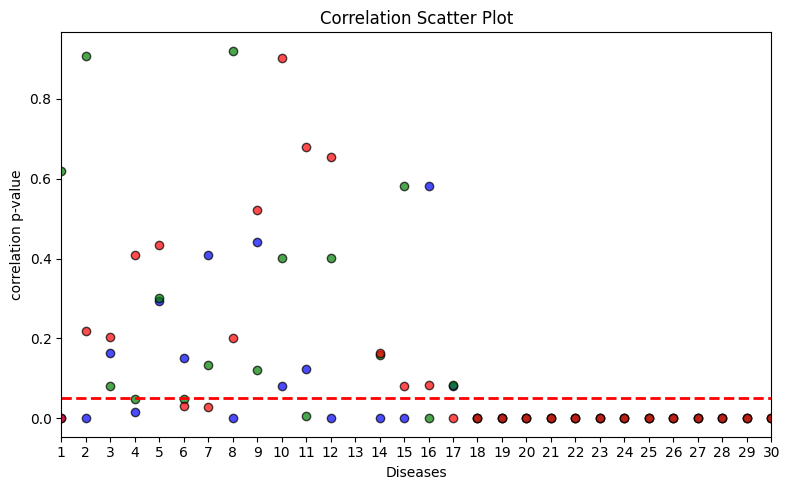

Length of Corr: 30
Length of features: 30


In [33]:
#This creates a scatter plot of diseases and thier p-values

features = np.arange(1, len(Corr_p_values) + 1)



plt.figure(figsize=(8,5))
plt.scatter(features, Corr_p_values[:,0], color='blue', edgecolors='black', alpha=0.7)
plt.scatter(features, Corr_p_values[:,1], color='green', edgecolors='black', alpha=0.7)
plt.scatter(features, Corr_p_values[:,2], color='red', edgecolors='black', alpha=0.7)
# Red line at y=0.05
plt.axhline(y=0.05, color='red', linestyle='--', linewidth=2)

plt.xlim(1, len(Corr_p_values))

plt.xticks(features)

plt.xlabel('Diseases')
plt.ylabel('correlation p-value')
plt.title('Correlation Scatter Plot')

plt.tight_layout()
plt.show()

# Verify lengths
print("Length of Corr:", len(Corr_p_values))
print("Length of features:", len(features))

(30, 3)
(30, 3)
[[7.28392604e-05            nan 1.28863878e-04]
 [1.69942675e-04            nan            nan]
 [           nan            nan            nan]
 [1.69881680e-02 4.82547927e-02            nan]
 [           nan            nan            nan]
 [           nan 4.95716970e-02 3.15633966e-02]
 [           nan            nan 2.90738890e-02]
 [1.63941890e-05            nan            nan]
 [           nan            nan            nan]
 [           nan            nan            nan]
 [           nan 6.92595881e-03            nan]
 [1.83684826e-04            nan            nan]
 [           nan            nan            nan]
 [7.16523237e-11            nan            nan]
 [0.00000000e+00            nan            nan]
 [           nan 0.00000000e+00            nan]
 [           nan            nan 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000

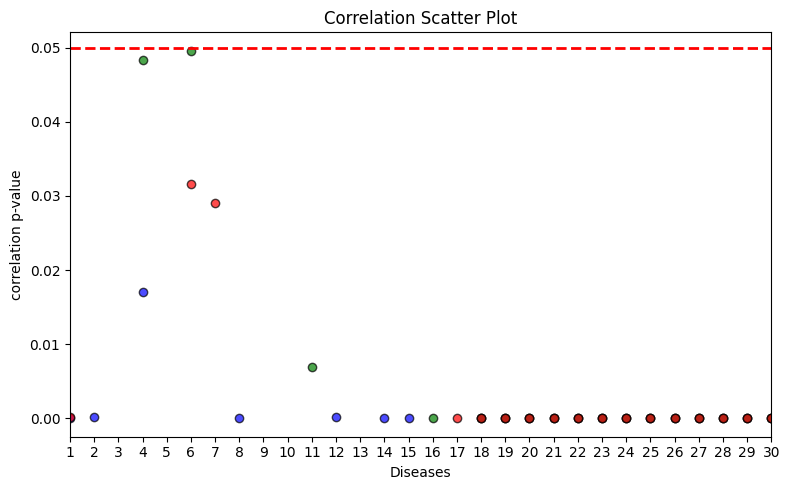

Length of Corr_significant: 30
Length of features: 30


In [34]:
#This filters the Corr matrix so that only statistically significant values (p<=0.05) remain
print(Corr_p_values.shape)

Corr_significat_p=Corr_p_values.copy() #if I dont use copy(), Corr also changes when I change Corr_significant
Corr_significat_p[Corr_significat_p > 0.05] = np.nan
print(Corr_significat_p.shape)
print(Corr_significat_p)

#This creates a scatter plot with statistically significant values

features = np.arange(1, len(Corr_significat_p) + 1)

plt.figure(figsize=(8,5))
plt.scatter(features, Corr_significat_p[:,0], color='blue', edgecolors='black', alpha=0.7)
plt.scatter(features, Corr_significat_p[:,1], color='green', edgecolors='black', alpha=0.7)
plt.scatter(features, Corr_significat_p[:,2], color='red', edgecolors='black', alpha=0.7)
# Red line at y=0.05
plt.axhline(y=0.05, color='red', linestyle='--', linewidth=2)

plt.xlim(1, len(Corr_p_values))

plt.xticks(features)

plt.xlabel('Diseases')
plt.ylabel('correlation p-value')
plt.title('Correlation Scatter Plot')

plt.tight_layout()
plt.show()

# Verify lengths
print("Length of Corr_significant:", len(Corr_significat_p))
print("Length of features:", len(features))

Now, as I want to present the data as a table I switch to dataframes as it makes it easier

In [35]:
correlation_p_value_df= pd.DataFrame(Corr_p_values, index=disease_columns, columns=pollutants)

significant_correlation_p_value_df = correlation_p_value_df.where(correlation_p_value_df <= 0.05, np.nan)

fig, ax = plt.subplots(figsize=(8, 10))
ax.axis('tight')
ax.axis('off')

ax.table(
    cellText=correlation_p_value_df.values, 
    colLabels=["Disease/Air Pollution"] + pollutants, 
    rowLabels=correlation_p_value_df.index, 
    cellLoc='center', 
    loc='center'
)
plt.show()

fig, ax = plt.subplots(figsize=(8, 10))
ax.axis('tight')
ax.axis('off')

ax.table(
    cellText=significant_correlation_p_value_df.values, 
    colLabels=["Disease/Air Pollution"] + pollutants, 
    rowLabels=significant_correlation_p_value_df.index, 
    cellLoc='center', 
    loc='center'
)
plt.show()


ValueError: Shape of passed values is (30, 3), indices imply (12, 3)

Now we want to filter the correlation coefficient data so that it leaves only the statistically signifficant coefficients

In [ ]:
sign_Corr_coef = np.where(Corr_p_values < 0.05, Corr_coef, np.nan)
sign_Corr_coef

correlation_coef_df= pd.DataFrame(Corr_coef, index=disease_columns, columns=pollutants)
sign_correlation_coef_df= pd.DataFrame(sign_Corr_coef, index=disease_columns, columns=pollutants)

fig, ax = plt.subplots(figsize=(8, 10))
ax.axis('tight')
ax.axis('off')

ax.table(
    cellText=correlation_coef_df.values, 
    colLabels=["Disease/Air Pollution"] + pollutants, 
    rowLabels=correlation_coef_df.index, 
    cellLoc='center', 
    loc='center'
)
plt.show()

fig, ax = plt.subplots(figsize=(8, 10))
ax.axis('tight')
ax.axis('off')

ax.table(
    cellText=sign_correlation_coef_df.values, 
    colLabels=["Disease/Air Pollution"] + pollutants, 
    rowLabels=sign_correlation_coef_df.index, 
    cellLoc='center', 
    loc='center'
)
plt.show()

